# Crop Invoice

Reference: https://www.kaggle.com/code/dmitryyemelyanov/receipt-ocr-part-1-image-segmentation-by-opencv

In [2]:
import cv2
import numpy as np

def getSubImage(rect, src):
    # Get center, size, and angle from rect
    center, size, theta = rect
    # Convert to int
    center, size = tuple(map(int, center)), tuple(map(int, size))
    # Get rotation matrix for rectangle
    M = cv2.getRotationMatrix2D( center, theta, 1)
    # Perform rotation on src image
    dst = cv2.warpAffine(src, M, src.shape[:2])
    out = cv2.getRectSubPix(dst, size, center)
    return out

img = cv2.imread('/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg')
# Find some contours
thresh2, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Get rotated bounding box
rect = cv2.minAreaRect(contours[0])
# Extract subregion
out = getSubImage(rect, img)
# Save image
cv2.imwrite('out.jpg', out)

error: ignored

In [3]:
import cv2
import numpy as np

def subimage(image, center, theta, width, height):

   '''
   Rotates OpenCV image around center with angle theta (in deg)
   then crops the image according to width and height.
   '''

   # Uncomment for theta in radians
   #theta *= 180/np.pi

   shape = ( image.shape[1], image.shape[0] ) # cv2.warpAffine expects shape in (length, height)

   matrix = cv2.getRotationMatrix2D( center=center, angle=theta, scale=1 )
   image = cv2.warpAffine( src=image, M=matrix, dsize=shape )

   x = int( center[0] - width/2  )
   y = int( center[1] - height/2 )

   image = image[ y:y+height, x:x+width ]

   return image

image = cv2.imread('/content/WhatsApp Image 2023-08-26 at 3.09.59 PM.jpeg')
image = subimage(image, center=(110, 125), theta=30, width=100, height=200)
cv2.imwrite('patch.jpg', image)

True

In [5]:
image.show()

AttributeError: ignored

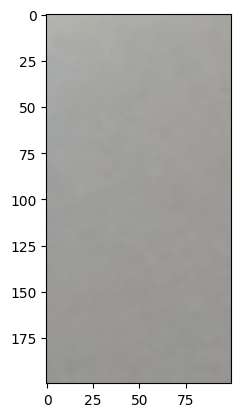

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(image)
plt.show()

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

print(cv2.__version__)

4.8.0


<ipython-input-43-f01c5c2c71b5>:3: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800,800), Image.ANTIALIAS)


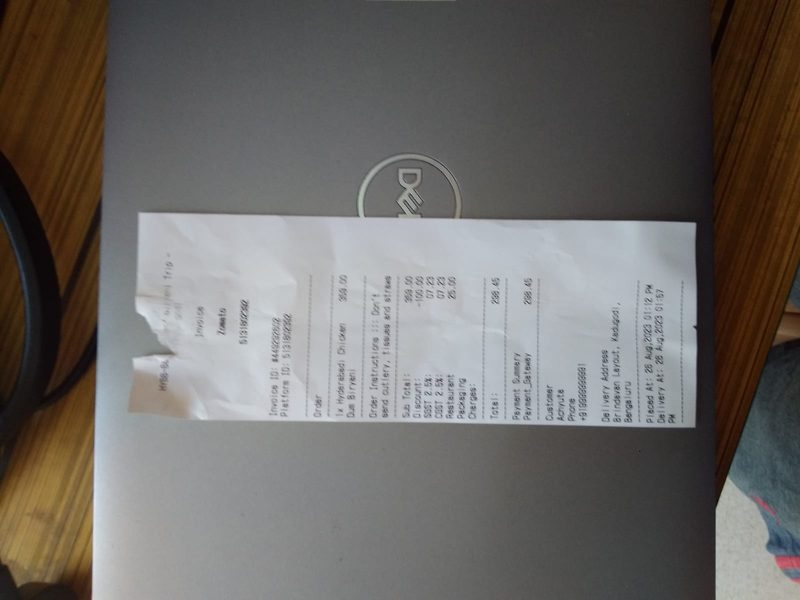

In [43]:
file_name = '/content/WhatsApp Image 2023-08-26 at 3.09.56 PM.jpeg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [44]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')



In [45]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

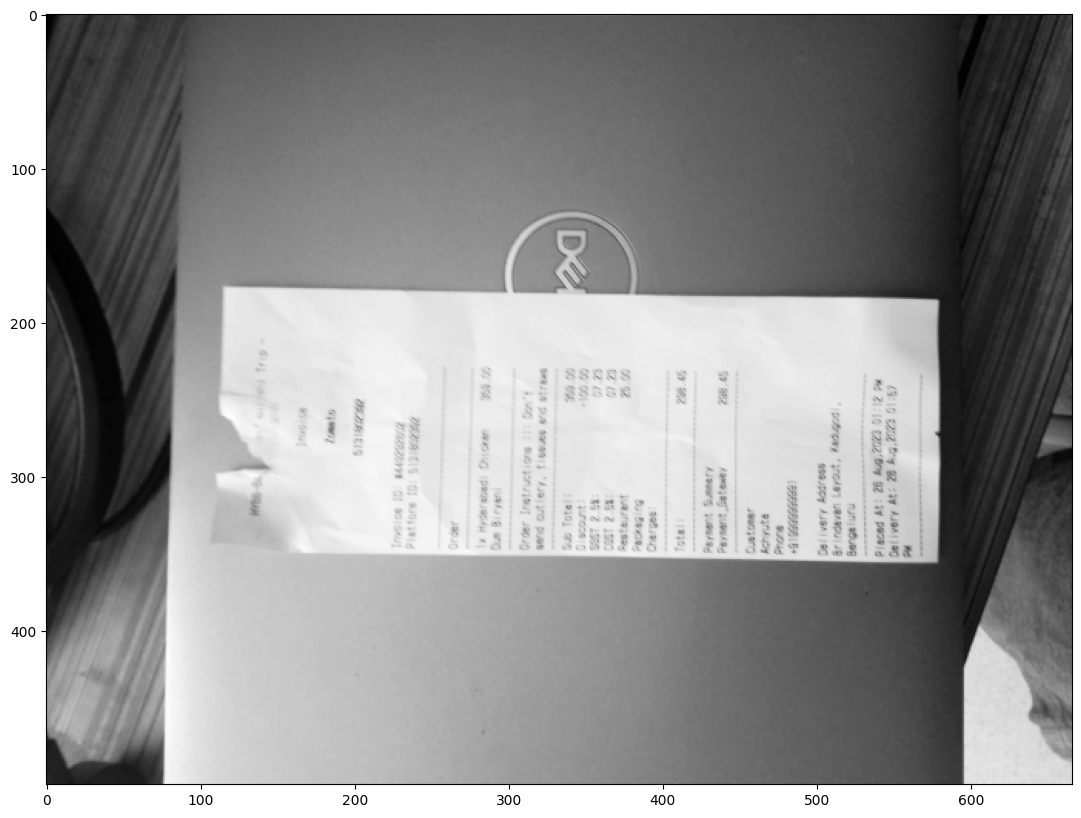

In [46]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

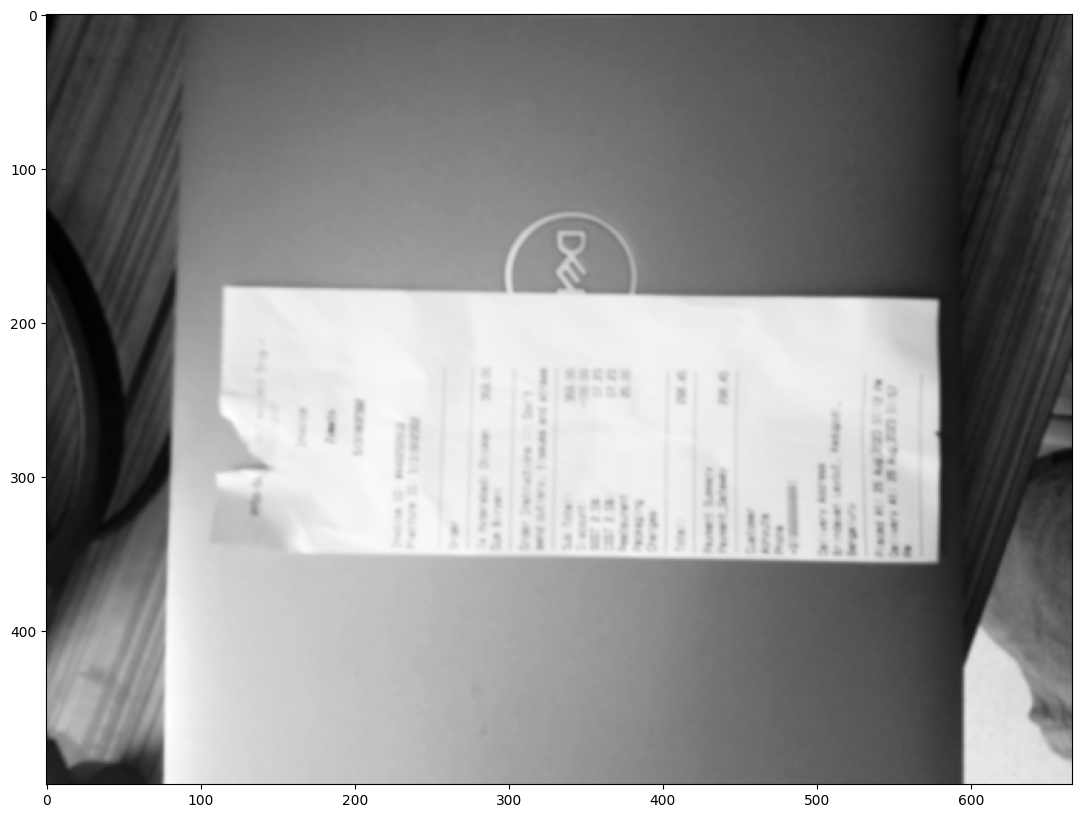

In [47]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

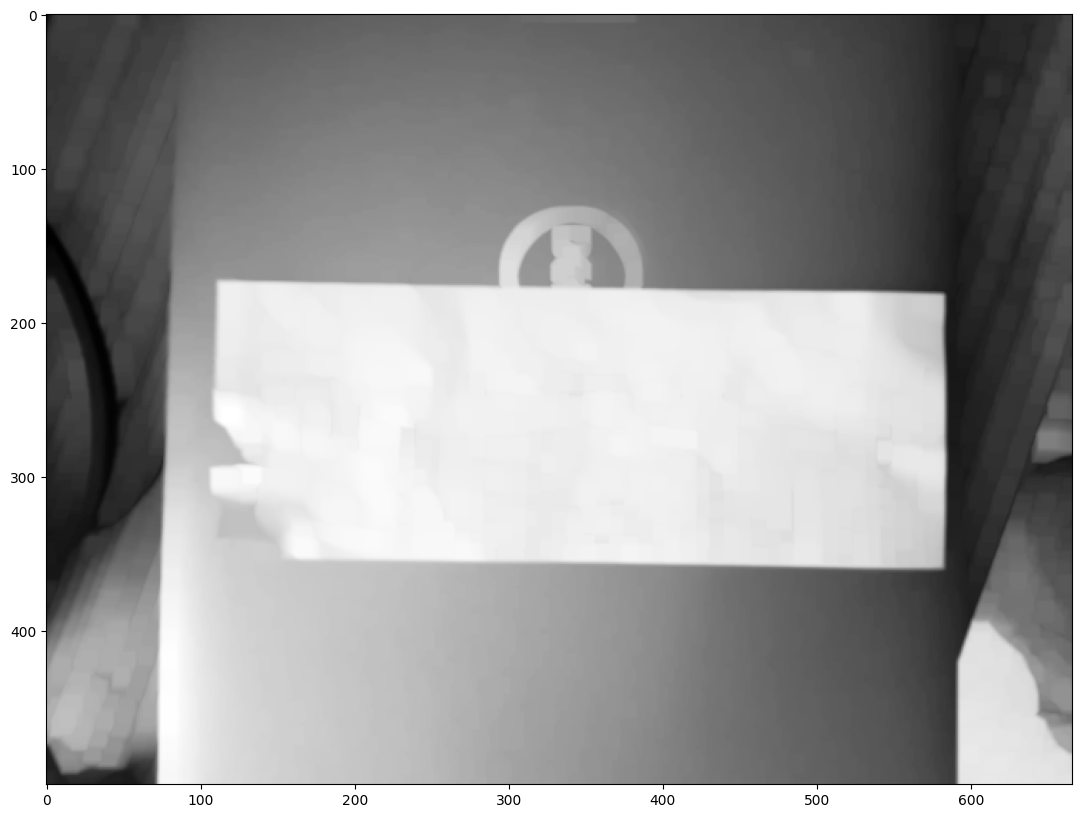

In [48]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

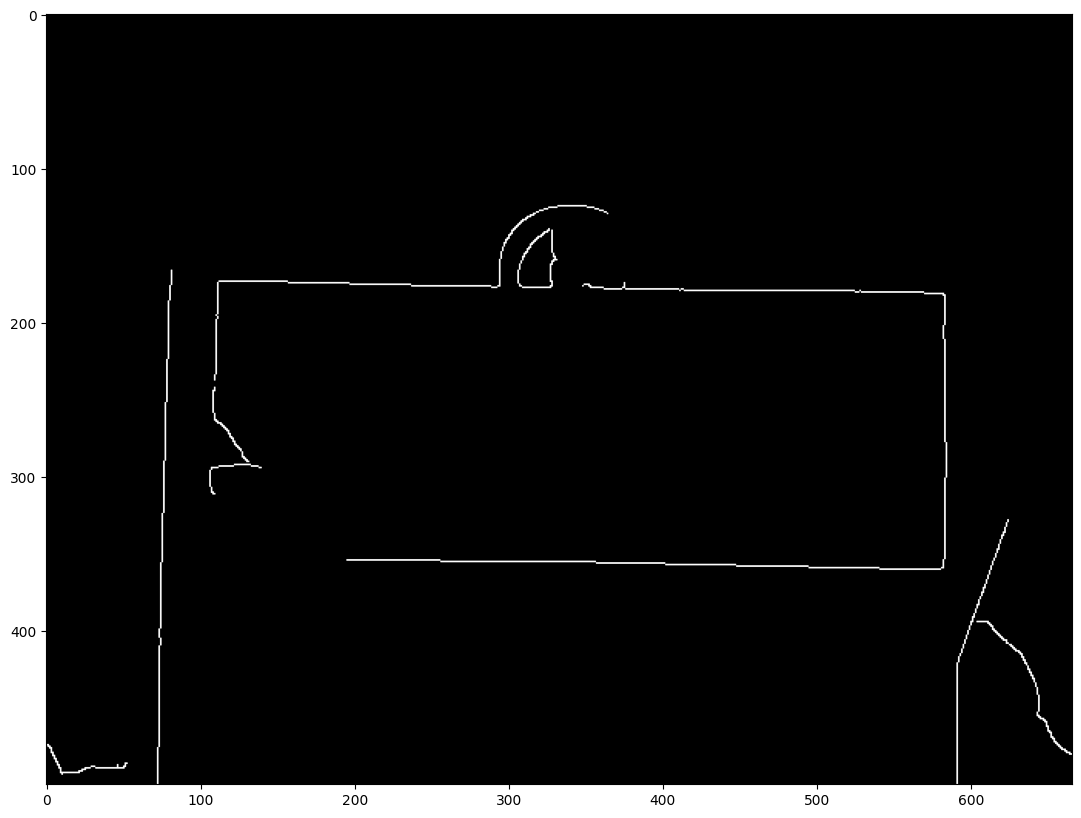

In [49]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

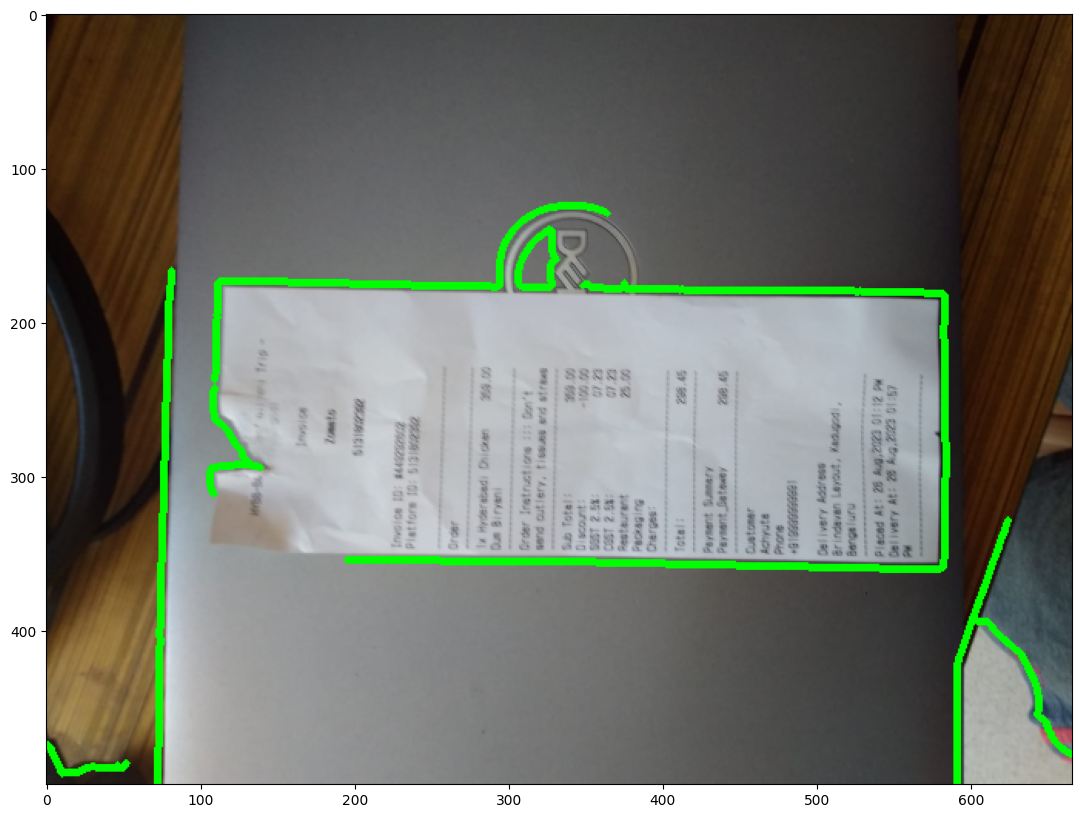

In [50]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

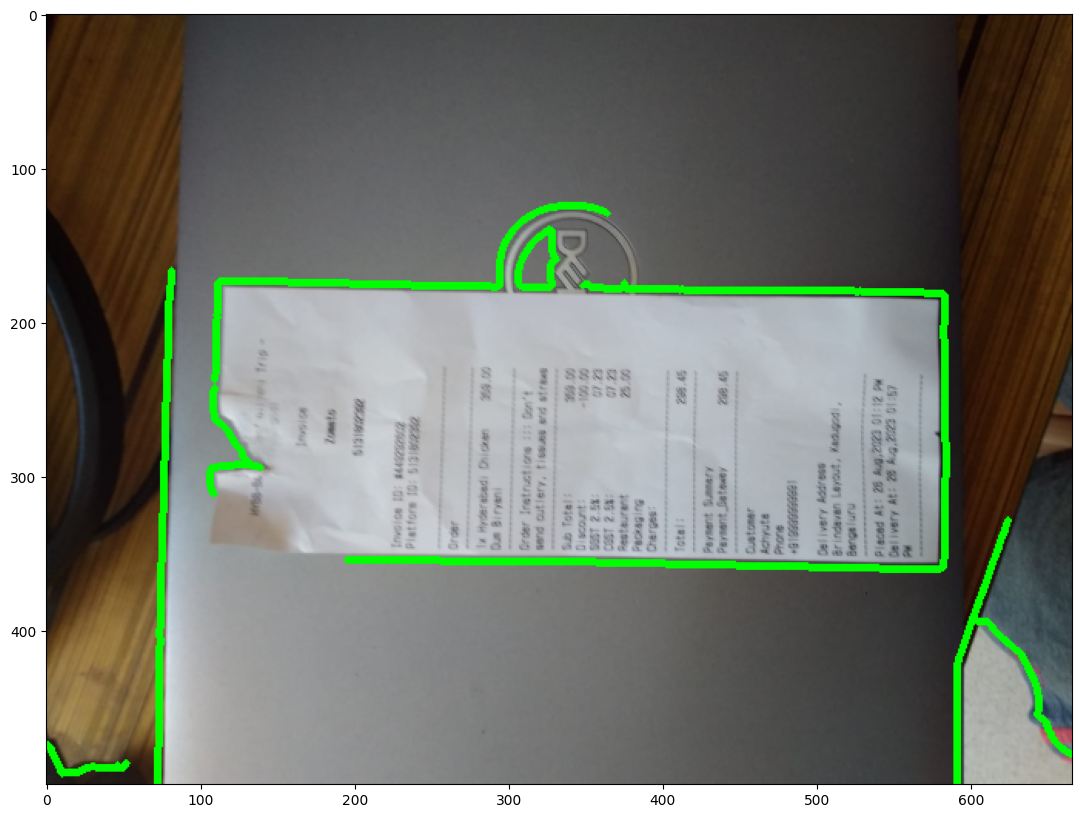

In [51]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [52]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [53]:
def get_receipt_contour(contours):
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        print(approx.shape)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) >= 4:
            return approx

In [54]:
get_receipt_contour(largest_contours)

(6, 1, 2)


array([[[604, 394]],

       [[633, 416]],

       [[643, 455]],

       [[665, 480]],

       [[643, 454]],

       [[633, 415]]], dtype=int32)

(6, 1, 2)
[[[604 394]]

 [[633 416]]

 [[643 455]]

 [[665 480]]

 [[643 454]]

 [[633 415]]]


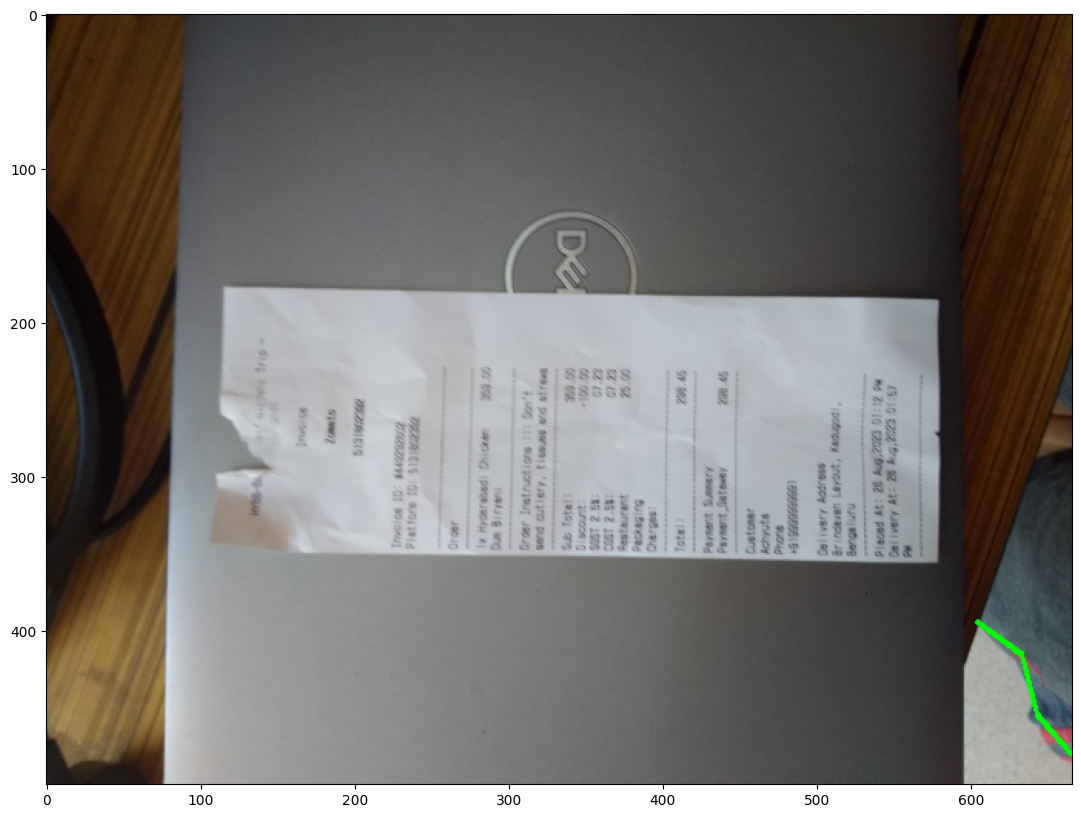

In [55]:
receipt_contour = get_receipt_contour(largest_contours)
print(receipt_contour)
receipt_contour = largest_contours if receipt_contour is None else receipt_contour
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [56]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [57]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

In [58]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

ValueError: ignored

In [38]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

In [39]:
result = bw_scanner(scanned)
plot_gray(result)

NameError: ignored

In [ ]:
output = Image.fromarray(result)
output.save('result.png')

In [4]:
#! pip install opencv-python

In [1]:
import cv2
import numpy as np

In [24]:
#WhatsApp Image 2023-08-26 at 3.09.58 PM
imgQ = cv2.imread(r'C:\Users\achyu\Downloads\WhatsApp Image 2023-08-26 at 3.09.58 PM.jpeg')

h,w,c = imgQ.shape
imgQ = cv2.resize(imgQ,(w//3,h//3))
orb = cv2.ORB_create(1000)
kp1,des1 = orb.detectAndCompute(imgQ,None)

#1st check
impKp1 = cv2.drawKeypoints(imgQ,kp1,None)
#cv2.imshow('keyPointQuery',impKp1)

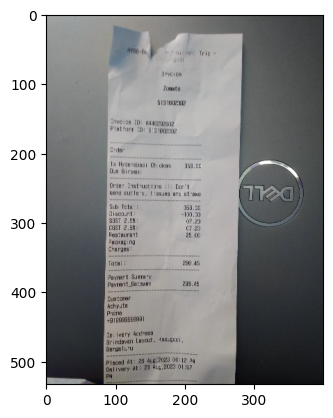

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(imgQ)
plt.show()

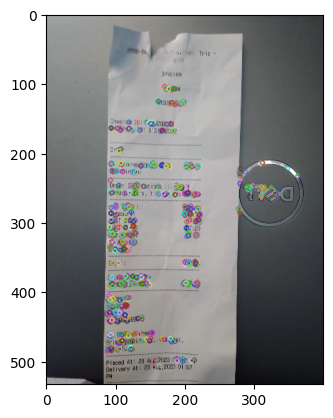

In [26]:
imgplot = plt.imshow(impKp1)
plt.show()

In [27]:
import os

path = r"C:\Users\achyu\Downloads"
myPicList = [i for i in os.listdir(path) if i.endswith(".jpeg") and i!='photo.jpeg']
myPicList = [i for i in myPicList if i=='WhatsApp Image 2023-08-26 at 3.09.56 PM.jpeg']
myPicList

['WhatsApp Image 2023-08-26 at 3.09.56 PM.jpeg']

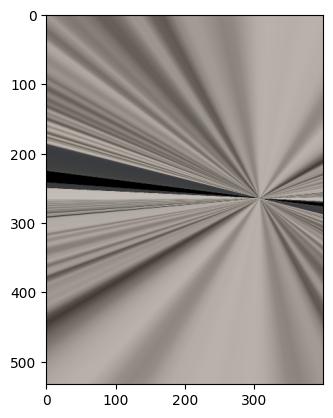

In [28]:
per = 25

for j,y in enumerate(myPicList):
    img = cv2.imread(path+'/'+y)
    #img = cv2.resize(img,(w//3,h//3))
    #cv2.imshow(y,img)
    kp2,des2 = orb.detectAndCompute(img,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = list(bf.match(des2,des1))
    matches.sort(key=lambda x: x.distance)
    good = matches[:int(len(matches)*(per/100))]
    imgMatch = cv2.drawMatches(img,kp2,imgQ,kp1,good[:100],None,flags=2)
    #imgMatch = cv2.resize(imgMatch,(w//3,h//3))
    #cv2.imshow(y,imgMatch)
    #np.float32([kp2[m.queryIdx].pt for m in good]).shape(-1,1,2)
    srcPoints = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dstPoints = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    M,_ = cv2.findHomography(srcPoints,dstPoints,cv2.RANSAC,5.8)
    imgScan = cv2.warpPerspective(img,M,(w,h))
    imgScan = cv2.resize(imgScan,(w//3,h//3))
    #cv2.imshow(y,imgScan)
    imgplot = plt.imshow(imgScan)
    plt.show()

In [ ]:
# i think this only works in form image